In [1]:
from typing import Callable

import numpy as np
import pandas as pd
from IPython.core.display import Markdown
from sklearn.model_selection import train_test_split

import notebooks.utils as nb_utils
from src.features.univariate_analysis import UACleaner
from src.utils import Dataset, Metadata, preprocess_init

STAGE = 1
PREVIOUS_STAGE = STAGE - 1
cfg = nb_utils.load_notebook_cfg()

%load_ext autoreload
%autoreload 2

## Load cleaned data and metadata in artifacts

In [2]:
df, metadata = nb_utils.load_artifacts(PREVIOUS_STAGE)

df.info(memory_usage="deep", max_cols=200)
print()

max_nans_for_rows = df.isna().sum(axis=1).max()
print(f"Max NaNs for rows: {max_nans_for_rows}")
print()

pd.options.display.max_rows = None

print("NaNs for cols")
nans_for_cols = nb_utils.get_nas(df)
display(nans_for_cols[nans_for_cols > 0])

pd.reset_option("display.max_rows", 0)

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 9249043 to 23246511
Data columns (total 164 columns):
 #    Column                                   Non-Null Count  Dtype         
---   ------                                   --------------  -----         
 0    name                                     29699 non-null  string        
 1    short_url                                29699 non-null  string        
 2    price                                    29699 non-null  UInt32        
 3    listing_followers_no                     26928 non-null  UInt16        
 4    location                                 29699 non-null  category      
 5    images_no                                29699 non-null  UInt8         
 6    description                              29699 non-null  string        
 7    gi_brand                                 29699 non-null  category      
 8    gi_model                                 29699 non-null  category      
 9    gi_production_year    

,missing count,missing [%]
ai_range_on_full_battery_km,29580,99.599313
gi_battery_capacity,29550,99.498300
ai_interest_free_credit,29513,99.373716
ai_leasing,28971,97.548739
gi_certified,28185,94.902185
ai_credit,27944,94.090710
ai_sales_method,26687,89.858244
ai_import_country,22175,74.665814
ai_floating_flywheel,20160,67.881073
ai_registered_until,12824,43.179905


In [3]:
def train_test_split_nb(df: Dataset) -> tuple[Dataset, Dataset]:
    df_train, df_test = train_test_split(
        df,
        test_size=cfg.test_size,
        random_state=cfg.random_seed,
    )
    return df_train, df_test

In [4]:
df_orig = df
# Using alias for df_train for making things easier and more neat
df, df_test = train_test_split_nb(df)

In [5]:
n_rows_train, n_cols_train = df.shape

print("Train dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_train}")
print(f"No of cols: {n_cols_train}")

print()

n_rows_test, n_cols_test = df_test.shape

print("Test dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_test}")
print(f"No of cols: {n_cols_test}")
print(20 * "-")

Train dataset shape
--------------------
No of rows: 23759
No of cols: 164

Test dataset shape
--------------------
No of rows: 5940
No of cols: 164
--------------------


## Univariate Analysis

### nominal features

In [6]:
@preprocess_init
def ua_nominal_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for nominal features")
    for col in features_info["nominal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.loc[df.gi_body_type == "", "gi_body_type"] = np.nan
    print("Replaced ' ' category for 'gi_body_type' with NaN")

    df.gi_fuel_type = pd.Categorical(
        df.gi_fuel_type.astype("object").replace(
            {
                "Hibridni pogon (Benzin)": "Hibridni pogon",
                "Hibridni pogon (Dizel)": "Hibridni pogon",
                "Plug-in hibrid": "Hibridni pogon",
                "Metan CNG": "Benzin + Metan (CNG)",
            }
        ),
        ordered=False,
    )
    print("Grouped simillar categories for 'gi_fuel_type'")

    df.ai_gearbox_type = pd.Categorical(
        df.ai_gearbox_type.astype("object").replace(
            {
                "Automatski": "Automatski / poluautomatski",
                "Poluautomatski": "Automatski / poluautomatski",
            }
        )
    )
    print("Grouped simillar categories for 'ai_gearbox_type'")

    constant_strat_cols = [
        "ai_floating_flywheel",
        "ai_interior_material",
        "ai_interior_color",
        "ai_ownership",
        "ai_import_country",
        "ai_sales_method",
    ]
    modus_strat_cols = [
        col for col in features_info["nominal"] if col not in constant_strat_cols
    ]
    cols_nan_strategy["const_unknown"].extend(constant_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN constant strategy columns:")
    print(constant_strat_cols)
    print("Extended 'constant' and 'modus' cols_nan_strategy")

    return df, metadata

In [7]:
df, metadata = ua_nominal_features(df=df, metadata=metadata)

Frequencies for nominal features


,count,percentage [%]
location,,
Beograd,3828,16.111789
Novi Sad,1709,7.193064
Niš,954,4.015321
Kragujevac,883,3.716486
Čačak,730,3.072520
...,...,...
Jug Bogdanovac,1,0.004209
Pudarci,1,0.004209
KRALJEVO,1,0.004209


,count,percentage [%]
gi_brand,,
Volkswagen,3734,15.716150
Audi,2529,10.644387
BMW,2151,9.053411
Opel,1862,7.837030
Peugeot,1582,6.658529
...,...,...
Mahindra,1,0.004209
Moskvitch,1,0.004209
Oldsmobile,1,0.004209


,count,percentage [%]
gi_model,,
A4,670,2.819984
A3,526,2.213898
A6,494,2.079212
Octavia,487,2.049750
Golf 7,443,1.864557
...,...,...
Musso,1,0.004209
Corolla Cross,1,0.004209
Multivan,1,0.004209


,count,percentage [%]
gi_body_type,,
Hečbek,8201,34.517446
Džip/SUV,4620,19.445263
Limuzina,4405,18.540343
Karavan,3603,15.164780
Monovolumen (MiniVan),1909,8.034850
Kupe,629,2.647418
Kabriolet/Roadster,249,1.048024
Pickup,142,0.597668
,1,0.004209


,count,percentage [%]
gi_fuel_type,,
Dizel,16285,68.542447
Benzin,5816,24.479145
Benzin + Gas (TNG),904,3.804874
Benzin + Metan (CNG),423,1.780378
Hibridni pogon,180,0.757608
Električni pogon,117,0.492445
Hibridni pogon (Benzin),19,0.079970
Hibridni pogon (Dizel),12,0.050507
Plug-in hibrid,2,0.008418


,count,percentage [%]
gi_trade_in,,
NE,17431,73.365882
DA,2988,12.576287
DA (za jeftinije),2223,9.356454
DA (za skuplje),778,3.274549
DA (u istoj ceni),339,1.426828


,count,percentage [%]
ai_floating_flywheel,,
NaN,16151,67.978450
Sa plivajućim zamajcem,4890,20.581674
Bez plivajućeg zamajca,2718,11.439875


,count,percentage [%]
ai_gearbox_type,,
Manuelni 5 brzina,8530,35.902184
Manuelni 6 brzina,7985,33.608317
Automatski / poluautomatski,7104,29.900248
Manuelni 4 brzine,129,0.542952
Automatski,10,0.042089
Poluautomatski,1,0.004209


,count,percentage [%]
ai_air_conditioning,,
Automatska klima,16023,67.439707
Manuelna klima,6937,29.197357
Nema klimu,799,3.362936


,count,percentage [%]
ai_color,,
Siva,7636,32.139400
Crna,6160,25.927017
Bela,3478,14.638663
Plava,2205,9.280694
Crvena,1090,4.587735
Srebrna,581,2.445389
Teget,578,2.432762
Braon,452,1.902437
Zelena,399,1.679364


,count,percentage [%]
ai_interior_material,,
Štof,12881,54.215245
Prirodna koža,3984,16.768383
NaN,3250,13.679027
Kombinovana koža,2891,12.168021
Drugi,388,1.633065
Velur,365,1.536260


,count,percentage [%]
ai_interior_color,,
Crna,12106,50.953323
Siva,4606,19.386338
NaN,4125,17.361842
Druga,1326,5.581043
Bež,1086,4.570899
Smeđa,510,2.146555


,count,percentage [%]
ai_propulsion,,
Prednji,17324,72.915527
4x4,3846,16.187550
Zadnji,2122,8.931352
4x4 reduktor,467,1.965571


,count,percentage [%]
ai_vehicle_origin,,
Domaće tablice,14538,61.189444
Na ime kupca,9079,38.212888
Strane tablice,142,0.597668


,count,percentage [%]
ai_ownership,,
Vodi se na prodavca,10199,42.926891
NaN,9244,38.907361
Ne vodi se na prodavca,4316,18.165748


,count,percentage [%]
ai_import_country,,
NaN,17749,74.704323
Švajcarska,1615,6.797424
Italija,1091,4.591944
Francuska,959,4.036365
Nemačka,826,3.476577
Holandija,555,2.335957
Belgija,298,1.254262
Norveška,209,0.879667
Austrija,171,0.719727


,count,percentage [%]
ai_sales_method,,
NaN,21341,89.822804
Komisiona,2201,9.263858
Konsignaciona,217,0.913338


Dropped empty categories

Replaced ' ' category for 'gi_body_type' with NaN
Grouped simillar categories for 'gi_fuel_type'
Grouped simillar categories for 'ai_gearbox_type'
NaN constant strategy columns:
['ai_floating_flywheel', 'ai_interior_material', 'ai_interior_color', 'ai_ownership', 'ai_import_country', 'ai_sales_method']
Extended 'constant' and 'modus' cols_nan_strategy


### ordinal features

In [8]:
@preprocess_init
def ua_ordinal_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for ordinal features")
    for col in features_info["ordinal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.ai_damage = df.ai_damage.cat.reorder_categories(
        ["Nije oštećen", "Oštećen - u voznom stanju", "Oštećen - nije u voznom stanju"]
    )
    print("Corrected order of 'ai_damage' categories")

    modus_strat_cols = ["ai_engine_emission_class", "ai_damage"]
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN modus strategy columns:")
    print(modus_strat_cols)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

In [9]:
df, metadata = ua_ordinal_features(df=df, metadata=metadata)

Frequencies for ordinal features


,count,percentage [%]
ai_engine_emission_class,,
4,7140,30.051770
6,6911,29.087925
5,6632,27.913633
3,2559,10.770655
2,304,1.279515
1,212,0.892293
NaN,1,0.004209


,count,percentage [%]
ai_damage,,
Nije oštećen,23465,98.762574
Oštećen - u voznom stanju,176,0.740772
Oštećen - nije u voznom stanju,116,0.488236
NaN,2,0.008418


Dropped empty categories

Corrected order of 'ai_damage' categories
NaN modus strategy columns:
['ai_engine_emission_class', 'ai_damage']
Extended 'modus' cols_nan_strategy


### numerical features

In [10]:
@preprocess_init
def ua_numerical_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    idx_to_remove = metadata.idx_to_remove
    cols_nan_strategy = metadata.cols_nan_strategy

    for col in features_info["numerical"]:
        # display(Markdown("#### Feature 'images_no'"))
        nb_utils.show_hist_box_numerical_col(df, col)
        print()

    const_strat_cols_zero = [
        "listing_followers_no",
        "gi_battery_capacity",
        "ai_range_on_full_battery_km",
    ]
    cols_scheduled_for_deletion = [
        "gi_battery_capacity",
        "ai_range_on_full_battery_km",
    ]
    median_strat_cols = [
        col
        for col in features_info["numerical"]
        if col not in const_strat_cols_zero + cols_scheduled_for_deletion
    ]

    df_cars_with_0_kilometerage = df[df.gi_kilometerage == 0]
    print(f"Cars with 'gi_kilometerage' = 0: {df_cars_with_0_kilometerage.shape[0]}")

    df.drop(df_cars_with_0_kilometerage.index, inplace=True)
    idx_to_remove.extend(df_cars_with_0_kilometerage.index.to_list())
    print("Removed cars with 'gi_kilometerage' = 0")
    print()

    display(df.loc[df.gi_engine_capacity > 5_000])
    df.loc[df.gi_engine_capacity > 5_000, "gi_engine_capacity"] = np.nan
    print(
        "Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)"
    )
    print()

    print(
        "Cars where 'gi_production_year' = 2024: ",
        (df.gi_production_year == 2024).sum(),
    )
    print()

    listing_names_less_30_hp = df.loc[df.gi_engine_power < 30, "name"].values
    print(
        f"Listing names of cars where 'gi_engine_power' < 30 (horse power): {listing_names_less_30_hp}"
    )
    print()

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)
    print("Dropped 'gi_battery_capacity' (too many zero values)")
    print("Dropped 'ai_range_on_full_battery_km' (too many zero values)")

    cols_nan_strategy["const_0"].extend(const_strat_cols_zero)
    cols_nan_strategy["median"].extend(median_strat_cols)
    print("NaN fill by 0 strategy columns:")
    print(const_strat_cols_zero)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

Univariate analysis of 'listing_followers_no' column
Histogram and box plot


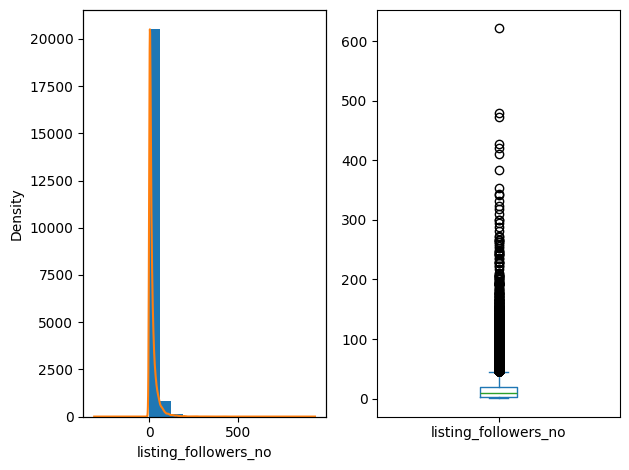

Descriptive statistics


count      21538.0
mean      17.29766
std      26.474305
min            1.0
25%            3.0
50%            9.0
75%           20.0
max          621.0
Name: listing_followers_no, dtype: Float64

Variance: 1.5305136729925775
Skewness: 5.318028864394972
Kurtosis: 53.17000208697701

NA values
Count [n]: 2221
Percentage [%]: 9.348036533524139%

Univariate analysis of 'images_no' column
Histogram and box plot


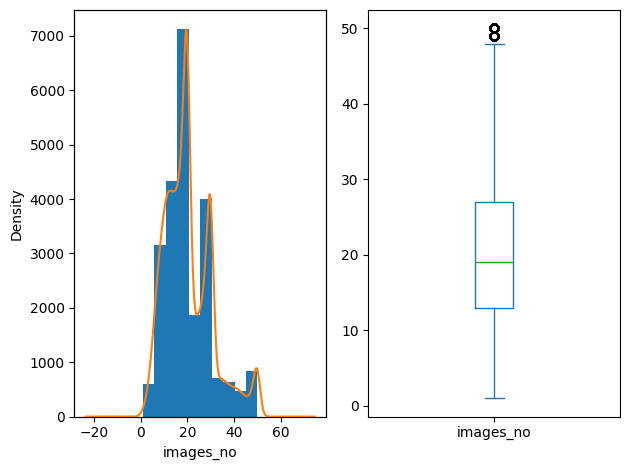

Descriptive statistics


count      23759.0
mean     20.419462
std      10.180147
min            1.0
25%           13.0
50%           19.0
75%           27.0
max           50.0
Name: images_no, dtype: Float64

Variance: 0.4985511812028104
Skewness: 0.878354071265468
Kurtosis: 0.6535785094458149

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_kilometerage' column
Histogram and box plot


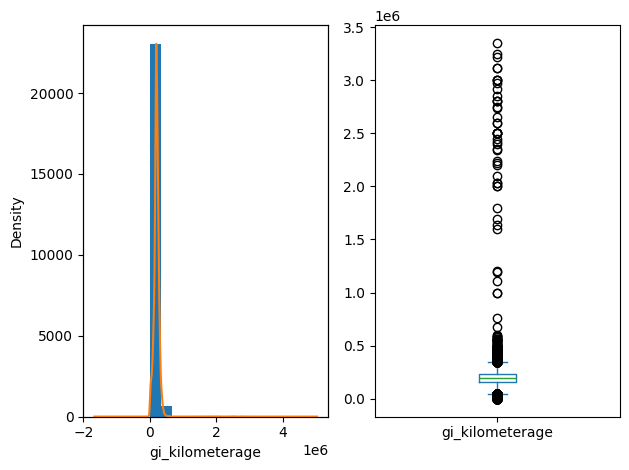

Descriptive statistics


count          23759.0
mean     200016.656509
std      122005.883785
min              500.0
25%           161191.0
50%           195657.0
75%           235600.0
max          3350000.0
Name: gi_kilometerage, dtype: Float64

Variance: 0.6099786183551935
Skewness: 13.34408317807227
Kurtosis: 276.3997013258057

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_production_year' column
Histogram and box plot


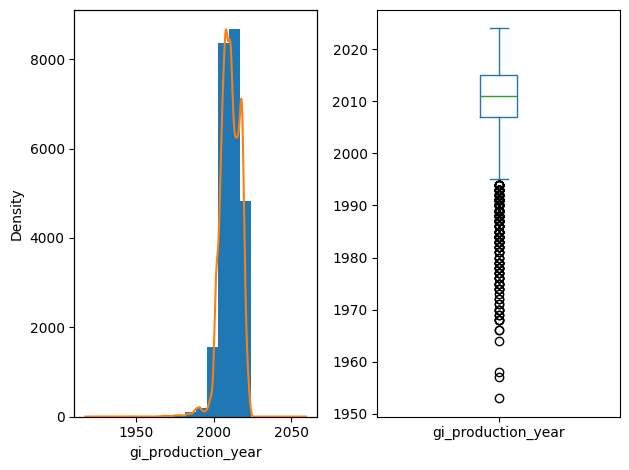

Descriptive statistics


count        23759.0
mean     2010.594722
std         6.255566
min           1953.0
25%           2007.0
50%           2011.0
75%           2015.0
max           2024.0
Name: gi_production_year, dtype: Float64

Variance: 0.003111301320885119
Skewness: -0.9226276184122038
Kurtosis: 3.586507118144622

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_engine_capacity' column
Histogram and box plot


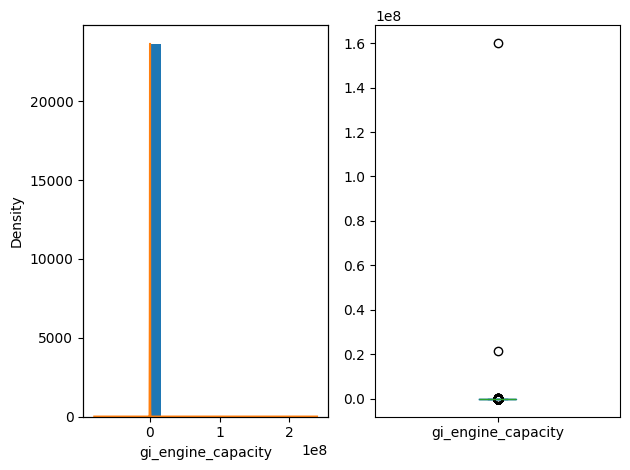

Descriptive statistics


count           23642.0
mean        9536.327637
std      1050245.027182
min               100.0
25%              1461.0
50%              1793.0
75%              1991.0
max         160051414.0
Name: gi_engine_capacity, dtype: Float64

Variance: 110.13097149465884
Skewness: 150.04447638045144
Kurtosis: 22814.352500570716

NA values
Count [n]: 117
Percentage [%]: 0.49244496822256834%

Univariate analysis of 'gi_engine_power' column
Histogram and box plot


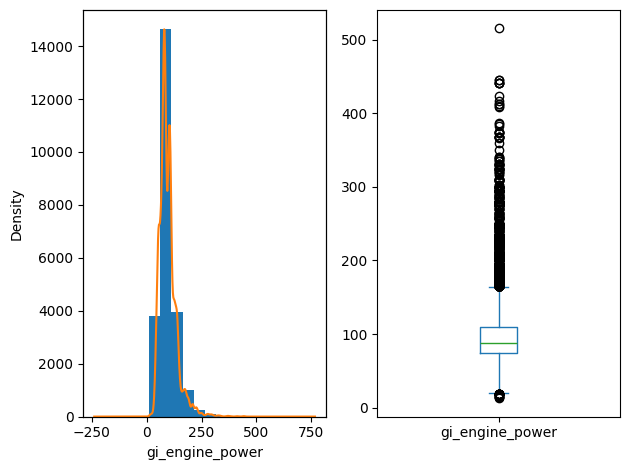

Descriptive statistics


count    23759.000000
mean        97.038428
std         39.477014
min         13.000000
25%         74.000000
50%         88.000000
75%        110.000000
max        515.000000
Name: gi_engine_power, dtype: float64

Variance: 0.4068183598141904
Skewness: 2.025841589376873
Kurtosis: 8.344381911135915

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_battery_capacity' column
Histogram and box plot


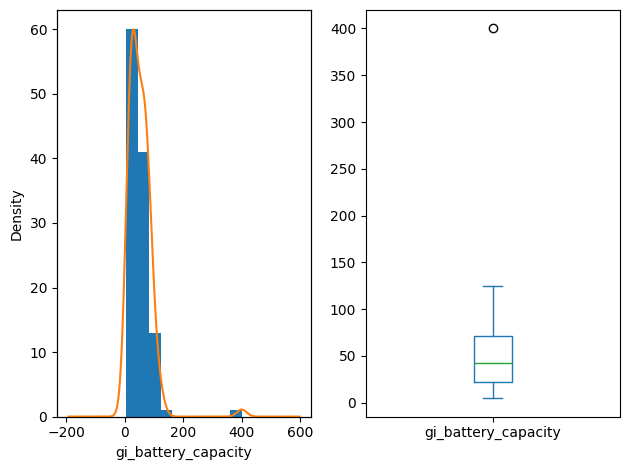

Descriptive statistics


count        116.0
mean     51.811724
std      43.114809
min            5.0
25%           22.0
50%           42.6
75%           71.7
max          400.0
Name: gi_battery_capacity, dtype: Float64

Variance: 0.8321438864121891
Skewness: 4.6415421894473505
Kurtosis: 34.71488288678014

NA values
Count [n]: 23643
Percentage [%]: 99.51176396312977%

Univariate analysis of 'ai_seats_no' column
Histogram and box plot


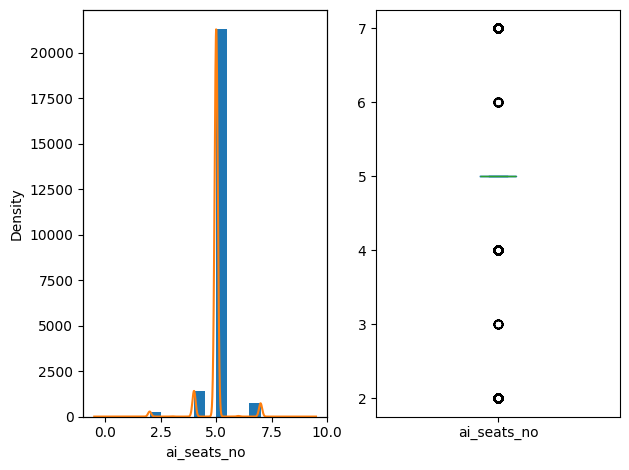

Descriptive statistics


count     23759.0
mean     4.967044
std      0.538883
min           2.0
25%           5.0
50%           5.0
75%           5.0
max           7.0
Name: ai_seats_no, dtype: Float64

Variance: 0.10849163991729807
Skewness: -0.6708416928382714
Kurtosis: 14.72344568291511

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'ai_range_on_full_battery_km' column
Histogram and box plot


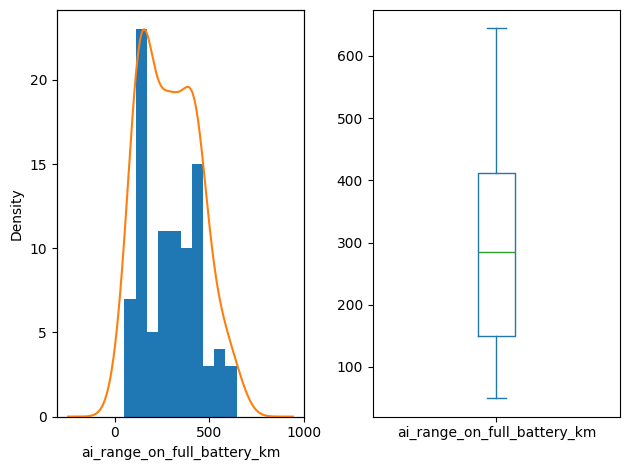

Descriptive statistics


count          92.0
mean     290.119565
std      151.392136
min            50.0
25%           150.0
50%           285.0
75%           412.5
max           644.0
Name: ai_range_on_full_battery_km, dtype: Float64

Variance: 0.5218267035978718
Skewness: 0.3354290192662526
Kurtosis: -0.8119523676232374

NA values
Count [n]: 23667
Percentage [%]: 99.61277831558567%

Cars with 'gi_kilometerage' = 0: 0
Removed cars with 'gi_kilometerage' = 0



,name,short_url,price,listing_followers_no,location,images_no,description,gi_brand,gi_model,gi_production_year,...,o_Garažiran,o_Kupljen_nov_u_Srbiji,o_Oldtimer,o_Prilagođeno_invalidima,o_Prvi_vlasnik,o_Restauriran,o_Rezervni_ključ,o_Servisna_knjiga,o_Test_vozilo,o_Tuning
id,,,,,,,,,,,,,,,,,,,,,
22509514,Audi S8,https://www.polovniautomobili.com/auto-oglasi/...,20000,37,Beograd,14,"●Auto u perfektnom stanju ●Motor,menjac,trap o...",Audi,S8,2007,...,True,False,False,False,False,False,False,False,False,False
22503872,Mercedes Benz E 200 CDi Classic,https://www.polovniautomobili.com/auto-oglasi/...,4500,6,Čačak,20,Uslužna prodaja- Vozilo se nalazi kod nas Polo...,Mercedes Benz,E 200,2004,...,False,False,False,False,False,False,True,False,False,False
23224823,Dacia Lodgy CH,https://www.polovniautomobili.com/auto-oglasi/...,6500,<NA>,Aleksinac,11,Dacia Lodgy -2013 -1.2 tce 115ks Potrošnja ben...,Dacia,Lodgy,2013,...,True,False,False,False,False,False,True,True,False,False
22641836,BMW X3,https://www.polovniautomobili.com/auto-oglasi/...,7200,1,Sremska Mitrovica,18,Na ime kupca Odlicno stanje Dva kljuca,BMW,X3,2008,...,False,False,False,False,False,False,False,False,False,False
23164860,"Fiat 500 1,2",https://www.polovniautomobili.com/auto-oglasi/...,5200,1,Kraljevo,7,,Fiat,500,2009,...,False,False,False,False,True,False,True,True,False,False
23227500,Opel Zafira 1.6cng,https://www.polovniautomobili.com/auto-oglasi/...,7600,<NA>,Pančevo,14,"auto je u ekstra stanju,redovno servisiran,vel...",Opel,Zafira,2013,...,False,False,False,False,False,False,False,False,False,False
23220591,Volkswagen Golf 5,https://www.polovniautomobili.com/auto-oglasi/...,4600,3,Smederevo,10,Na automobilu sve radi Motor menjac trap zamaj...,Volkswagen,Golf 5,2007,...,True,True,False,False,True,False,False,False,False,False
23172473,Volkswagen Touran,https://www.polovniautomobili.com/auto-oglasi/...,2700,3,Novi Pazar,10,"Touran 1,9 105 ks Cena kes 2 700",Volkswagen,Touran,2006,...,False,False,False,False,False,False,False,False,False,False
22630402,Bentley Continental flying super Long,https://www.polovniautomobili.com/auto-oglasi/...,55000,6,Subotica,30,Na prodaju: Bentley continental flying spur 6....,Bentley,Continental,2007,...,True,False,False,False,False,False,False,False,False,False


Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)

Cars where 'gi_production_year' = 2024:  1

Listing names of cars where 'gi_engine_power' < 30 (horse power): <StringArray>
[             'Renault Twizy',  'Zastava 750 presla 38.400',
                'Trabant 601', 'Renault Twizy elektro  8kw',
                'Zastava 750',      'Volkswagen Buba 1200J',
         'Suzuki Maruti 2007',                'Zastava 750',
                'Trabant 601',     'Renault Twizy eletktro',
           'Fiat Cinquecento',              'Renault Twizy',
             'Renault R 4 tl',                'Zastava 850',
     'Volkswagen Buba 1200 J',          'Fiat Seicento 0.9',
         'Zastava 750 750 le',                'Zastava 750',
                'Opel Kadett',              'ZhiDou D2 Nav',
         'Citroen 2CV spaček',            'Renault R 4 gtl',
      'Zastava 750 LE sa Reg',            'Zastava 750 750',
                'Zastava 750',          'Fiat 500L Berli

In [11]:
df, metadata = ua_numerical_features(df=df, metadata=metadata)

### binary features

In [12]:
@preprocess_init
def ua_binary_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    display(Markdown("### Categories for every binary column"))
    for col in features_info["binary"]:
        display(nb_utils.get_value_counts_freq_with_perc(df, col))

    cols_scheduled_for_deletion = [
        "e_Fabrički_ugrađeno_dečije_sedište",
        "e_Volan_u_kombinaciji_drvo_ili_koža",
        "o_Oldtimer",
        "o_Prilagođeno_invalidima",
        "o_Restauriran",
        "o_Test_vozilo",
        "o_Tuning",
    ]
    print(f"Columns scheduled for deletion:\n{cols_scheduled_for_deletion}")
    print()

    const_false_strat_cols = ["ai_credit", "ai_interest_free_credit", "ai_leasing"]
    modus_strat_cols = [
        col
        for col in features_info["binary"]
        if col not in cols_scheduled_for_deletion + const_false_strat_cols
    ]
    print("NaN fill by False strategy columns:")
    print(const_false_strat_cols)
    print()

    cols_nan_strategy["const_false"].extend(const_false_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("Extended 'const_false' and 'modus' cols_nan_strategy")

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)

    return df, metadata

In [13]:
df, metadata = ua_binary_features(df=df, metadata=metadata)

### Categories for every binary column

,count,percentage [%]
s_ABS,,
True,22044,92.781683
False,1715,7.218317


,count,percentage [%]
s_ASR,,
True,17123,72.069532
False,6636,27.930468


,count,percentage [%]
s_Airbag_za_suvozača,,
True,22192,93.404605
False,1567,6.595395


,count,percentage [%]
s_Airbag_za_vozača,,
True,22341,94.031735
False,1418,5.968265


,count,percentage [%]
s_Alarm,,
False,17350,73.024959
True,6409,26.975041


,count,percentage [%]
s_Asistencija_praćenja_trake,,
False,20442,86.038975
True,3317,13.961025


,count,percentage [%]
s_Automatsko_kočenje,,
False,20240,85.188771
True,3519,14.811229


,count,percentage [%]
s_Blokada_motora,,
False,17296,72.797677
True,6463,27.202323


,count,percentage [%]
s_Bočni_airbag,,
True,20542,86.459868
False,3217,13.540132


,count,percentage [%]
s_Centralno_zaključavanje,,
True,21837,91.910434
False,1922,8.089566


,count,percentage [%]
s_Child_lock,,
True,13194,55.53264
False,10565,44.46736


,count,percentage [%]
s_ESP,,
True,18128,76.299508
False,5631,23.700492


,count,percentage [%]
s_Kodiran_ključ,,
True,15040,63.302328
False,8719,36.697672


,count,percentage [%]
s_Mehanička_zaštita,,
False,22316,93.926512
True,1443,6.073488


,count,percentage [%]
s_OBD_zaštita,,
False,19205,80.832527
True,4554,19.167473


,count,percentage [%]
s_Senzor_mrtvog_ugla,,
False,21849,91.960941
True,1910,8.039059


,count,percentage [%]
s_Ulazak_bez_ključa,,
False,20044,84.36382
True,3715,15.63618


,count,percentage [%]
s_Vazdušni_jastuci_za_kolena,,
False,18817,79.199461
True,4942,20.800539


,count,percentage [%]
e_360_kamera,,
False,22962,96.645482
True,797,3.354518


,count,percentage [%]
e_AUX_konekcija,,
False,13625,57.34669
True,10134,42.65331


,count,percentage [%]
e_Adaptivna_svetla,,
False,19177,80.714677
True,4582,19.285323


,count,percentage [%]
e_Adaptivni_tempomat,,
False,20402,85.870617
True,3357,14.129383


,count,percentage [%]
e_Aluminijumske_felne,,
True,16764,70.558525
False,6995,29.441475


,count,percentage [%]
e_Ambijentalno_osvetljenje,,
False,20553,86.506166
True,3206,13.493834


,count,percentage [%]
e_Android_Auto,,
False,21439,90.235279
True,2320,9.764721


,count,percentage [%]
e_Apple_CarPlay,,
False,21523,90.588829
True,2236,9.411171


,count,percentage [%]
e_Asistencija_za_kretanje_na_uzbrdici,,
False,15187,63.92104
True,8572,36.07896


,count,percentage [%]
e_Automatsko_parkiranje,,
False,22129,93.139442
True,1630,6.860558


,count,percentage [%]
e_Automatsko_zatamnjivanje_retrovizora,,
False,17110,72.014815
True,6649,27.985185


,count,percentage [%]
e_Autonomna_vožnja,,
False,22915,96.447662
True,844,3.552338


,count,percentage [%]
e_Bluetooth,,
False,13119,55.21697
True,10640,44.78303


,count,percentage [%]
e_Branici_u_boji_auta,,
True,15297,64.384023
False,8462,35.615977


,count,percentage [%]
e_Brisači_prednjih_farova,,
False,21557,90.731933
True,2202,9.268067


,count,percentage [%]
e_CD_changer,,
False,20691,87.086999
True,3068,12.913001


,count,percentage [%]
e_DPF_filter,,
False,13963,58.769308
True,9796,41.230692


,count,percentage [%]
e_DVD_ili_TV,,
False,21432,90.205817
True,2327,9.794183


,count,percentage [%]
e_Daljinsko_zaključavanje,,
True,20115,84.662654
False,3644,15.337346


,count,percentage [%]
e_Digitalni_radio,,
False,18493,77.835767
True,5266,22.164233


,count,percentage [%]
e_Dnevna_svetla,,
True,12390,52.148659
False,11369,47.851341


,count,percentage [%]
e_Držači_za_čaše,,
True,18323,77.120249
False,5436,22.879751


,count,percentage [%]
e_Ekran_na_dodir,,
False,17881,75.259902
True,5878,24.740098


,count,percentage [%]
e_Električni_podizači,,
True,21657,91.152826
False,2102,8.847174


,count,percentage [%]
e_Električni_retrovizori,,
True,20150,84.809967
False,3609,15.190033


,count,percentage [%]
e_Elektro_otvaranje_prtljažnika,,
False,13695,57.641315
True,10064,42.358685


,count,percentage [%]
e_Elektro_podesiva_sedišta,,
False,18489,77.818932
True,5270,22.181068


,count,percentage [%]
e_Elektro_sklopivi_retrovizori,,
False,17123,72.069532
True,6636,27.930468


,count,percentage [%]
e_Elektro_zatvaranje_prtljažnika,,
False,21750,91.544257
True,2009,8.455743


,count,percentage [%]
e_Elektronska_ručna_kočnica,,
False,16600,69.86826
True,7159,30.13174


,count,percentage [%]
e_Fabrički_ugrađeno_dečije_sedište,,
False,23679,99.663285
True,80,0.336715


,count,percentage [%]
e_Glasovne_komande,,
False,19542,82.250936
True,4217,17.749064


,count,percentage [%]
e_Grejanje_sedišta,,
False,17526,73.765731
True,6233,26.234269


,count,percentage [%]
e_Grejanje_volana,,
False,23010,96.84751
True,749,3.15249


,count,percentage [%]
e_Grejači_retrovizora,,
True,17645,74.266594
False,6114,25.733406


,count,percentage [%]
e_Grejači_vetrobranskog_stakla,,
False,19130,80.516857
True,4629,19.483143


,count,percentage [%]
e_Hands_free,,
False,16526,69.5568
True,7233,30.4432


,count,percentage [%]
e_Hard_disk,,
False,22193,93.408814
True,1566,6.591186


,count,percentage [%]
e_Head_up_display,,
False,22931,96.515005
True,828,3.484995


,count,percentage [%]
e_ISOFIX_sistem,,
True,17075,71.867503
False,6684,28.132497


,count,percentage [%]
e_Indikator_niskog_pritiska_u_gumama,,
False,14080,59.261753
True,9679,40.738247


,count,percentage [%]
e_Kamera,,
False,20005,84.199672
True,3754,15.800328


,count,percentage [%]
e_Keramičke_kočnice,,
False,23573,99.217139
True,186,0.782861


,count,percentage [%]
e_Kožni_volan,,
True,15241,64.148323
False,8518,35.851677


,count,percentage [%]
e_Krovni_nosač,,
False,17745,74.687487
True,6014,25.312513


,count,percentage [%]
e_Kuka_za_vuču,,
False,21155,89.039943
True,2604,10.960057


,count,percentage [%]
e_LED_prednja_svetla,,
False,15901,66.926217
True,7858,33.073783


,count,percentage [%]
e_LED_zadnja_svetla,,
False,15931,67.052485
True,7828,32.947515


,count,percentage [%]
e_MP3,,
False,13159,55.385328
True,10600,44.614672


,count,percentage [%]
e_Masažna_sedišta,,
False,23178,97.554611
True,581,2.445389


,count,percentage [%]
e_Matrix_farovi,,
False,22600,95.121849
True,1159,4.878151


,count,percentage [%]
e_Memorija_sedišta,,
False,22247,93.636096
True,1512,6.363904


,count,percentage [%]
e_Metalik_boja,,
True,13689,57.616061
False,10070,42.383939


,count,percentage [%]
e_Modovi_vožnje,,
False,19545,82.263563
True,4214,17.736437


,count,percentage [%]
e_Multifunkcionalni_volan,,
True,15297,64.384023
False,8462,35.615977


,count,percentage [%]
e_Multimedija,,
False,14449,60.814849
True,9310,39.185151


,count,percentage [%]
e_Naslon_za_ruku,,
True,15185,63.912623
False,8574,36.087377


,count,percentage [%]
e_Navigacija,,
False,15266,64.253546
True,8493,35.746454


,count,percentage [%]
e_Ostava_sa_hlađenjem,,
False,15886,66.863083
True,7873,33.136917


,count,percentage [%]
e_Otvor_za_skije,,
False,20609,86.741866
True,3150,13.258134


,count,percentage [%]
e_Paljenje_bez_ključa,,
False,18728,78.824866
True,5031,21.175134


,count,percentage [%]
e_Panorama_krov,,
False,21854,91.981986
True,1905,8.018014


,count,percentage [%]
e_Parking_senzori,,
False,12830,54.000589
True,10929,45.999411


,count,percentage [%]
e_Podešavanje_volana_po_visini,,
True,19198,80.803064
False,4561,19.196936


,count,percentage [%]
e_Postolje_za_bežično_punjenje_telefona,,
False,22905,96.405573
True,854,3.594427


,count,percentage [%]
e_Prednja_noćna_kamera,,
False,23419,98.568963
True,340,1.431037


,count,percentage [%]
e_Privlačenje_vrata_pri_zatvaranju,,
False,23345,98.257502
True,414,1.742498


,count,percentage [%]
e_Putni_računar,,
True,18490,77.823141
False,5269,22.176859


,count,percentage [%]
e_Radio_CD,,
True,16797,70.69742
False,6962,29.30258


,count,percentage [%]
e_Radio_ili_Kasetofon,,
True,13607,57.270929
False,10152,42.729071


,count,percentage [%]
e_Retrovizor_se_obara_pri_rikvercu,,
False,21062,88.648512
True,2697,11.351488


,count,percentage [%]
e_Rezervni_točak,,
False,12366,52.047645
True,11393,47.952355


,count,percentage [%]
e_Ručice_za_menjanje_brzina_na_volanu,,
False,21073,88.69481
True,2686,11.30519


,count,percentage [%]
e_Sedišta_podesiva_po_visini,,
True,16395,69.00543
False,7364,30.99457


,count,percentage [%]
e_Senzori_za_kišu,,
True,12465,52.464329
False,11294,47.535671


,count,percentage [%]
e_Senzori_za_svetla,,
False,11903,50.09891
True,11856,49.90109


,count,percentage [%]
e_Servo_volan,,
True,22232,93.572962
False,1527,6.427038


,count,percentage [%]
e_Sportska_sedišta,,
False,19311,81.278673
True,4448,18.721327


,count,percentage [%]
e_Sportsko_vešanje,,
False,21654,91.1402
True,2105,8.8598


,count,percentage [%]
e_Start_stop_sistem,,
False,17463,73.500568
True,6296,26.499432


,count,percentage [%]
e_Subwoofer,,
False,22213,93.492992
True,1546,6.507008


,count,percentage [%]
e_Svetla_za_maglu,,
True,17304,72.831348
False,6455,27.168652


,count,percentage [%]
e_Tempomat,,
True,14632,61.585084
False,9127,38.414916


,count,percentage [%]
e_Tonirana_stakla,,
True,18473,77.751589
False,5286,22.248411


,count,percentage [%]
e_Torba_za_skije,,
False,23394,98.46374
True,365,1.53626


,count,percentage [%]
e_USB,,
False,14082,59.270171
True,9677,40.729829


,count,percentage [%]
e_Upravljanje_na_sva_četiri_točka,,
False,23004,96.822257
True,755,3.177743


,count,percentage [%]
e_Utičnica_od_12V,,
True,16342,68.782356
False,7417,31.217644


,count,percentage [%]
e_Vazdušno_vešanje,,
False,23046,96.999032
True,713,3.000968


,count,percentage [%]
e_Ventilacija_sedišta,,
False,23340,98.236458
True,419,1.763542


,count,percentage [%]
e_Virtuelna_tabla,,
False,22237,93.594006
True,1522,6.405994


,count,percentage [%]
e_Volan_u_kombinaciji_drvo_ili_koža,,
False,23631,99.461257
True,128,0.538743


,count,percentage [%]
e_Webasto,,
False,22990,96.763332
True,769,3.236668


,count,percentage [%]
e_Xenon_svetla,,
False,18160,76.434193
True,5599,23.565807


,count,percentage [%]
e_Zaključavanje_diferencijala,,
False,23063,97.070584
True,696,2.929416


,count,percentage [%]
e_Zavesice_na_zadnjim_prozorima,,
False,22829,96.085694
True,930,3.914306


,count,percentage [%]
e_Šiber,,
False,22258,93.682394
True,1501,6.317606


,count,percentage [%]
o_Garancija,,
False,17754,74.725367
True,6005,25.274633


,count,percentage [%]
o_Garažiran,,
False,14366,60.465508
True,9393,39.534492


,count,percentage [%]
o_Kupljen_nov_u_Srbiji,,
False,21645,91.102319
True,2114,8.897681


,count,percentage [%]
o_Oldtimer,,
False,23691,99.713793
True,68,0.286207


,count,percentage [%]
o_Prilagođeno_invalidima,,
False,23753,99.974746
True,6,0.025254


,count,percentage [%]
o_Prvi_vlasnik,,
False,19270,81.106107
True,4489,18.893893


,count,percentage [%]
o_Restauriran,,
False,23710,99.793762
True,49,0.206238


,count,percentage [%]
o_Rezervni_ključ,,
False,11995,50.486132
True,11764,49.513868


,count,percentage [%]
o_Servisna_knjiga,,
False,13398,56.391262
True,10361,43.608738


,count,percentage [%]
o_Test_vozilo,,
False,23694,99.726419
True,65,0.273581


,count,percentage [%]
o_Tuning,,
False,23641,99.503346
True,118,0.496654


,count,percentage [%]
ai_doors_no,,
True,21264,89.498716
False,2493,10.492866
<NA>,2,0.008418


,count,percentage [%]
ai_credit,,
<NA>,22362,94.120123
True,1397,5.879877


,count,percentage [%]
ai_interest_free_credit,,
<NA>,23605,99.351825
True,154,0.648175


,count,percentage [%]
ai_leasing,,
<NA>,23166,97.504104
True,593,2.495896


Columns scheduled for deletion:
['e_Fabrički_ugrađeno_dečije_sedište', 'e_Volan_u_kombinaciji_drvo_ili_koža', 'o_Oldtimer', 'o_Prilagođeno_invalidima', 'o_Restauriran', 'o_Test_vozilo', 'o_Tuning']

NaN fill by False strategy columns:
['ai_credit', 'ai_interest_free_credit', 'ai_leasing']

Extended 'const_false' and 'modus' cols_nan_strategy


### other features

In [14]:
@preprocess_init
def ua_other_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    # Subset of other columns
    other_columns = ["gi_certified", "ai_registered_until"]

    display(Markdown("### Descriptive statistics of other columns"))
    display(df[other_columns].describe())
    print("Missing values of other columns")
    nb_utils.get_nas(df[other_columns])  # type: ignore

    today_date = np.datetime64("2024-01")

    df.gi_certified = pd.to_numeric(
        (df.gi_certified - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    df.ai_registered_until = pd.to_numeric(
        (df.ai_registered_until - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    print(
        "Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates"
    )
    print()

    display(Markdown("### Univariate analysis of transformed other columns"))
    for col in other_columns:
        nb_utils.show_hist_box_numerical_col(df, col)
    print()

    cols_nan_strategy["const_0"].extend(other_columns)
    print("NaN constant 0 strategy columns:")
    print(other_columns)

    for col in other_columns:
        features_info["other"].remove(col)
    print(f"Removed {other_columns} from other features")

    features_info["numerical"].extend(other_columns)
    print(f"Added {other_columns} to numerical features")

    return df, metadata

### Descriptive statistics of other columns

,gi_certified,ai_registered_until
count,1195,13561
mean,2027-01-09 13:32:11.046024960,2024-07-08 12:12:22.246147328
min,2022-05-01 00:00:00,2021-06-01 00:00:00
25%,2025-10-16 12:00:00,2024-04-01 00:00:00
50%,2027-04-01 00:00:00,2024-07-01 00:00:00
75%,2028-01-01 00:00:00,2024-10-01 00:00:00
max,2033-12-01 00:00:00,2025-03-01 00:00:00


Missing values of other columns
Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates



### Univariate analysis of transformed other columns

Univariate analysis of 'gi_certified' column
Histogram and box plot


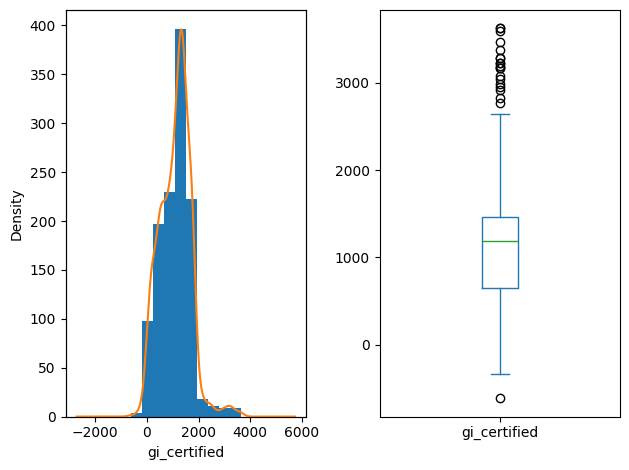

Descriptive statistics


count         1195.0
mean     1104.564017
std       597.730187
min           -610.0
25%            654.5
50%           1186.0
75%           1461.0
max           3622.0
Name: gi_certified, dtype: Float64

Variance: 0.5411458079409565
Skewness: 0.41702845583992876
Kurtosis: 1.2686864869798695

NA values
Count [n]: 22564
Percentage [%]: 94.97032703396607%
Univariate analysis of 'ai_registered_until' column
Histogram and box plot


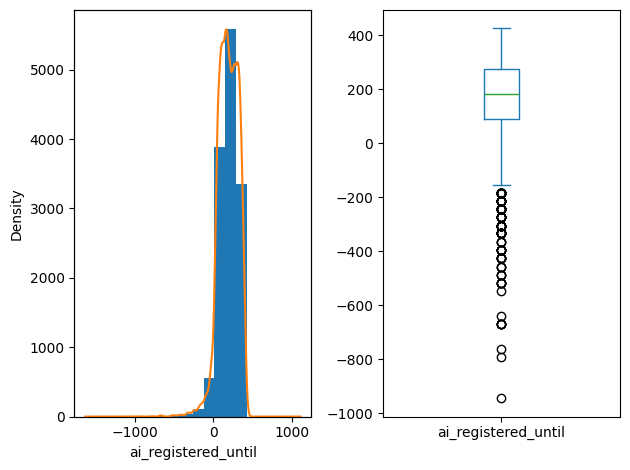

Descriptive statistics


count       13561.0
mean     189.508591
std      125.740289
min          -944.0
25%            91.0
50%           182.0
75%           274.0
max           425.0
Name: ai_registered_until, dtype: Float64

Variance: 0.6635070660599008
Skewness: -0.8788917482699471
Kurtosis: 3.063476867243576

NA values
Count [n]: 10198
Percentage [%]: 42.9226819310577%

NaN constant 0 strategy columns:
['gi_certified', 'ai_registered_until']
Removed ['gi_certified', 'ai_registered_until'] from other features
Added ['gi_certified', 'ai_registered_until'] to numerical features


In [15]:
df, metadata = ua_other_features(df=df, metadata=metadata)

## Testing

### Test individual components

In [16]:
def get_func_from_globals(func: Callable) -> Callable:
    result_func_name: str = func.__name__
    result_func: Callable = globals()[result_func_name]

    if not callable(result_func):
        raise Exception(
            f"Provided function {func.__name__} is not a function in globals."
        )
    return result_func


class TestNotebook(nb_utils.TestNotebookGeneric):
    # Testing only df_train
    def test_single_funcs(self):
        transf_obj: UACleaner = self.transformer_obj  # type: ignore

        df_prep, metadata_prep = nb_utils.load_artifacts(PREVIOUS_STAGE)
        # Get df_train
        df_prep, _ = train_test_split_nb(df)

        all_funcs_to_test: list[Callable] = [
            transf_obj.ua_nominal_features,
            transf_obj.ua_ordinal_features,
            transf_obj.ua_numerical_features,
            transf_obj.ua_binary_features,
        ]

        for func_to_test in all_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(
                func_to_test,
                get_func_from_globals(func_to_test),
                df=df_prep,
                metadata=metadata_prep,
            )

    def test_whole_component(self, df_nb: Dataset, metadata_nb: Metadata):
        df_init_py, metadata_init_py = nb_utils.load_artifacts(PREVIOUS_STAGE)
        df_init_py, _ = train_test_split_nb(df_init_py)
        self._test_whole_component_complex(
            df_init_py, metadata_init_py, df_nb, metadata_nb
        )

In [ ]:
test_obj = TestNotebook(UACleaner(), label_col=cfg.label_col)
test_obj.test_single_funcs()

### Test whole component

In [ ]:
test_obj.test_whole_component(df_nb=df, metadata_nb=metadata)

## Save cleaned data and metadata in artifacts

In [ ]:
nb_utils.save_artifacts(STAGE, df, metadata)